In [1]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table

### Pandas
import pandas as pd

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 30})

### Functions used in this code
import age_functions as afunc
import extinction as extinct
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757} # mircons

### Stuff Writtten by A Really Cool Professor
from dlnpyutils import utils as dln

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

<font size='45'>
    <b>
        Import Data
    </b>
</font>

# PARSEC Isochrones

In [2]:
# 12 Gyr
parsec12e9 = pd.read_csv('/Users/joshuapovick/Desktop/Research/parsec/parsec12e9.dat',comment='#',
                     names=["Zini","MH","logAge","Mini","int_IMF","Mass","logL","logTe","logg","label","McoreTP",
                            "C_O","period0","period1","period2","period3","period4","pmode","Mloss","tau1m","X",
                            "Y","Xc","Xn","Xo","Cexcess","Z","mbolmag","Gmag","G_BPmag","G_RPmag","B_Tmag",
                            "V_Tmag","Jmag","Hmag","Ksmag"],sep='\s+')

parsec12e9 = Table.from_pandas(parsec12e9)
parsec12e9 = parsec12e9[np.where(parsec12e9['label']==3)]

p12e9_2_2 = parsec12e9[np.where(parsec12e9['MH']==dln.closest(parsec12e9['MH'],-2.2)[0])]
p12e9_1_0 = parsec12e9[np.where(parsec12e9['MH']==dln.closest(parsec12e9['MH'],-1.0)[0])]
p12e9_0_0 = parsec12e9[np.where(parsec12e9['MH']==dln.closest(parsec12e9['MH'],0.0)[0])]

# 5 Gyr
parsec5e9 = pd.read_csv('/Users/joshuapovick/Desktop/Research/parsec/parsec5e9.dat',comment='#',
                     names=["Zini","MH","logAge","Mini","int_IMF","Mass","logL","logTe","logg","label","McoreTP",
                            "C_O","period0","period1","period2","period3","period4","pmode","Mloss","tau1m","X",
                            "Y","Xc","Xn","Xo","Cexcess","Z","mbolmag","Gmag","G_BPmag","G_RPmag","B_Tmag",
                            "V_Tmag","Jmag","Hmag","Ksmag"],sep='\s+')

parsec5e9 = Table.from_pandas(parsec5e9)
parsec5e9 = parsec5e9[np.where(parsec5e9['label']==3)]

p5e9_2_2 = parsec5e9[np.where(parsec5e9['MH']==dln.closest(parsec5e9['MH'],-2.2)[0])]
p5e9_1_0 = parsec5e9[np.where(parsec5e9['MH']==dln.closest(parsec5e9['MH'],-1.0)[0])]
p5e9_0_0 = parsec5e9[np.where(parsec5e9['MH']==dln.closest(parsec5e9['MH'],0.0)[0])]

# massive
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive.fits.gz',0)
massive = massive[np.where(massive['label']==3.0)]

# Globular Clusters

In [3]:
### GCS Data
gcs = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r13-l33-58932beta_apa_dist_galvel_gc.fits')
cln = np.where((gcs['FE_H']>-9999.0)&(gcs['AK_TARG']>-9999.0)&(gcs['LOGG']>0.0)&(gcs['M_H_ERR']>-90.0)&
                (gcs['C_FE']>-9999.0)&(gcs['N_FE']>-9999.0))
gcs = Table(gcs[cln])

### Add Harris values to gcs file
harris_dist = [4.5,4.4,6.4,4.8,7.1,10.4,8.8,11.5,3.2,10.2,2.2,7.5,17.9,26.5,5.4,10.3,4.0,12.9,8.3,12.1,9.6,8.9,
               4.9,8.6,19.3,17.4,16.0,8.9,30.5,9.5,5.9,10.4,9.9,2.3,11.6,7.7,3.0,10.9,8.1,8.7,4.0,7.4,23.2,5.8,
               8.2,7.1,10.9,5.2]
harris_ebv = [0.04,0.28,0.33,0.19,0.02,0.10,0.38,0.10,0.34,0.01,0.35,0.03,0.02,0.15,0.08,0.05,0.25,0.01,0.02,0.02,
              0.22,0.03,0.24,0.05,0.02,0.01,0.00,0.36,0.01,0.36,0.54,0.54,0.37,0.18,0.47,0.48,0.76,0.53,0.40,0.05,
              0.04,0.77,0.03,1.46,1.24,1.76,1.17,0.12]

gcs['harris_dist'] = np.zeros(len(gcs))
gcs['harris_ebv'] = -9999.0*np.ones(len(gcs))

for i in range(len(np.unique(gcs['CLUSTER']))):
    clus = np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])
    gcs['harris_dist'][clus] = harris_dist[i]
    gcs['harris_ebv'][clus] = harris_ebv[i]

In [4]:
### Find Cluster with more than one star

idx = []
for i in range(len(np.unique(gcs['CLUSTER']))):
    idx.append(np.squeeze(np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])))

for i in range(len(idx)):
    try:
        len(idx[i])
    except:
        print('bad: ',i)

bad:  24
bad:  27
bad:  37


In [5]:
### Find Clusters with more than 10 stars

good_names = []
for i in np.asarray(idx)[np.delete(np.asarray(list(range(len(idx)))),[24,27,37])]:
    if len(i)>10:
        good_names.append(gcs['CLUSTER'][i][0])

print(good_names)

['47Tuc', 'M10', 'M107', 'M12', 'M13', 'M19', 'M2', 'M22', 'M3', 'M4', 'M5', 'M53', 'M54', 'M55', 'M71', 'M79', 'NGC1851', 'NGC2808', 'NGC288', 'NGC3201', 'NGC362', 'NGC6388', 'NGC6397', 'NGC6752', 'omegaCen']


In [6]:
### Keep only Clusters with more than 10 members

good_clus = np.where((gcs['CLUSTER']=='47Tuc')|(gcs['CLUSTER']=='M10')|(gcs['CLUSTER']=='M107')|
                     (gcs['CLUSTER']=='M12')|(gcs['CLUSTER']=='M13')|(gcs['CLUSTER']=='M19')|
                     (gcs['CLUSTER']=='M2')|(gcs['CLUSTER']=='M22')|(gcs['CLUSTER']=='M3')|
                     (gcs['CLUSTER']=='M4')|(gcs['CLUSTER']=='M5')|(gcs['CLUSTER']=='M53')|
                     (gcs['CLUSTER']=='M54')|(gcs['CLUSTER']=='M55')|(gcs['CLUSTER']=='M71')|
                     (gcs['CLUSTER']=='M79')|(gcs['CLUSTER']=='NGC1851')|(gcs['CLUSTER']=='NGC2808')|
                     (gcs['CLUSTER']=='NGC288')|(gcs['CLUSTER']=='NGC3201')|(gcs['CLUSTER']=='NGC362')|
                     (gcs['CLUSTER']=='NGGC6388')|(gcs['CLUSTER']=='NGC6397')|(gcs['CLUSTER']=='NGC6752')|
                     (gcs['CLUSTER']=='omegaCen'))

gcs = gcs[good_clus]

In [415]:
# from scipy.interpolate import LinearNDInterpolator,NearestNDInterpolator
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.stats import binned_statistic

def closest(val,dat):
    '''
    find value closest to the given one
    
    Inputs:
    ------
        val: given value to find/get closest to
        dat: vals to search through
    
    Output:
    ------
        value in dat closest to val
    '''
    val = np.asarray(val)
    dat = np.asarray(dat)
    
    abs_diff = np.abs(dat - val)
    return dat[abs_diff.argmin()]

def parsec_teff2mag(teff,feh,band,age,isochrones):
    '''
    Calculate the intrinsic magnitude from a star's given temperture and metallicity using PARSEC isochrones
    
    Inputs:
    ------
        teff: temperature of star
        feh: metallicity of star
        band: [str] magnitude
        age: age in Gyr to use 
        isochrones: set of parsec isochrones
    Output:
    ------
        mag: expected intrinsic magnitude for the given temperature
    '''
    
    single = isochrones[np.where((isochrones['logAge']==closest(np.log10(age*10**9),isochrones['logAge']))&
                                 (isochrones['MH']==closest(feh,isochrones['MH'])))]
    
    sidx = np.argsort(single['logTe'])
    slogTe = single['logTe'][sidx]
    smag = single[band][sidx]

    _, ui = np.unique(slogTe,return_index=True)
    
    try:
        if np.log10(teff) > min(slogTe):
            spl = InterpolatedUnivariateSpline(slogTe[ui],smag[ui])
    
            mag = spl(np.log10(teff))
            return mag
        
        else:
            return -9999.0
    
    except:
        return -9999.0
    
def interp_MagAge(mags,ages):
    '''
    Interpolate ages as a function of magnitudes
    
    Inputs:
    ------
        mags: magnitudes
        ages: ages
        
    Outputs:
    -------
        spl: return scipy.interpolate.fitpack2.InterpolatedUnivariateSpline
    '''
    mags = np.asarray(mags)
    ages = np.asarray(ages)
    
    cut = np.where(mags!=-9999.0)
    
    sidx = np.argsort(mags[cut])
    smags = mags[cut][sidx]
    sages = ages[cut][sidx]
    
    try:
        spl = InterpolatedUnivariateSpline(smags,sages)
        return spl
    
    except:
        return -9999.0
    
def absMag(mag,dist,extinction):
    '''
    Calculate the absolute magnitude of a star
    
    Inputs:
    ------
        mag: apparent magnitude of star
        dist: distance in pc
        extinction: extinction in band of interest
        
    Output:
    ------
        amag: absolute magnitude
    '''
    amag = mag-5*np.log10(dist)+5-extinction
    return amag

In [551]:
def salaris(feh,aM):
        '''
        Calculate the Salaris et al. 1993 corrected metallicities using Asplund 2009
        
        Inputs:
        ------
            aM: [$\alpha$/M] for a star
            mh: [M/H] for a star
        
        Output:
        ------
            feh_sal: Salaris corrected [Fe/H]
        '''
        
#         asp={'C':8.43,'N':7.83,'O':8.69,'Mg':7.60,'Si':7.51,'S':7.12,'Ca':6.34,'Fe':7.50}
        
        
        
        return feh + np.log10(0.638*(10**aM)+0.362)

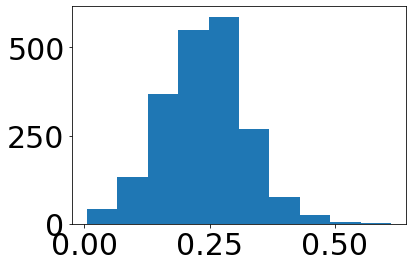

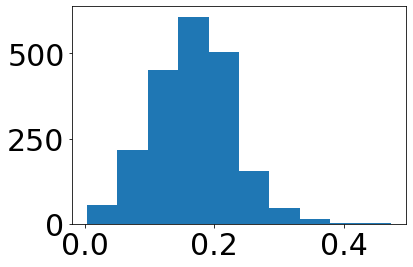

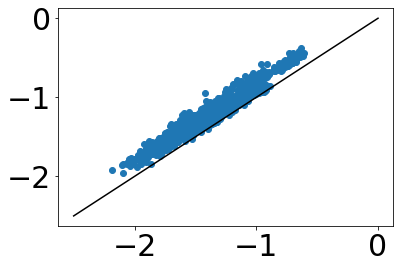

In [549]:
plt.hist(gcs['ALPHA_M']+gcs['M_H']-gcs['FE_H'])
plt.show()

plt.hist(np.log10(0.638*(10**(gcs['ALPHA_M']+gcs['M_H']-gcs['FE_H']))+0.362))
plt.show()

plt.scatter(gcs['FE_H'],gcs['FE_H']+np.log10(0.638*(10**(gcs['ALPHA_M']+gcs['M_H']-gcs['FE_H']))+0.362))
plt.plot([-2.5,0],[-2.5,0],c='k')
plt.show()

24.99999625598079
0.05541519372613606


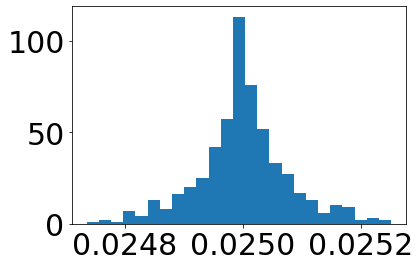

In [530]:
plt.hist(np.diff(10**np.unique(massive['logage'])/10**9),bins=25)
print(np.median(np.diff(10**np.unique(massive['logage'])))/10**6)
print(dln.mad(np.diff(10**np.unique(massive['logage'])))/10**6)

(array([  32.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2022.]),
 array([-9.9999902e+03, -8.9999062e+03, -7.9998228e+03, -6.9997393e+03,
        -5.9996558e+03, -4.9995723e+03, -3.9994885e+03, -2.9994048e+03,
        -1.9993213e+03, -9.9923761e+02,  8.4600818e-01], dtype=float32),
 <a list of 10 Patch objects>)

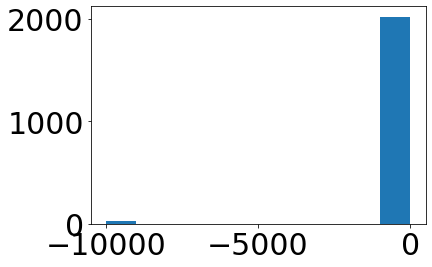

In [539]:
plt.hist(gcs['CA_FE'])

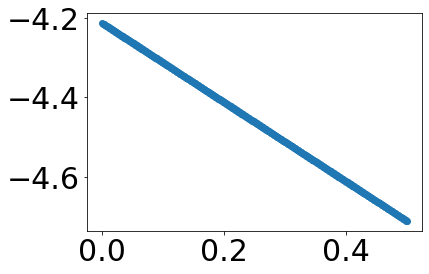

In [522]:
absMag_vals = []
for i in np.arange(0.0,0.5,0.001):
    absMag_vals.append(absMag(gcs['K'][g_idx],10000,i))
    
absMag_vals = np.asarray(absMag_vals)
plt.scatter(np.arange(0.0,0.5,0.001),absMag_vals)
# print(min(absMag_vals))

In [516]:
# xx,yy = np.meshgrid(np.arange(0.0,0.5,0.001),10**np.unique(massive['logAge'])/10**9,sparse=True)

# chi_top = (gcs['K'][g_idx]-5*np.log10(10400)+5-xx-
#            parsec_teff2mag(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'Ksmag',yy,massive))**2
# chi_bot = (gcs['TEFF_ERR'][g_idx]**2+gcs['FE_H_ERR'][g_idx]**2+gcs['K_ERR'][g_idx]**2)
# chis = chi_top/chi_bot

In [449]:
x = np.arange(0.0,0.5,0.01)
y = 10**np.unique(massive['logAge'])/10**9
chi_arr = np.zeros((len(x),len(y)))
for i in tqdm_notebook(range(len(x))):
    for j in tqdm_notebook(range(len(y)),leave=False):
        top = (gcs['K'][g_idx]-5*np.log10(10400)+5-x[i]-
               parsec_teff2mag(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'Ksmag',y[j],massive))**2
        bot = (gcs['TEFF_ERR'][g_idx]**2+gcs['FE_H_ERR'][g_idx]**2+gcs['K_ERR'][g_idx]**2)
        chi_arr[i,j] = top/bot

In [461]:
np.where(chi_arr==np.min(chi_arr))

(array([13]), array([328]))

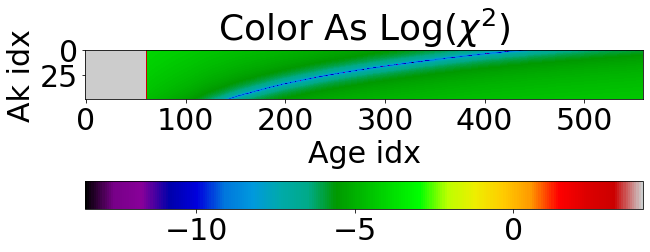

In [579]:
plt.figure(figsize=[10,10])
plt.imshow(np.log10(chi_arr),cmap='nipy_spectral')
plt.colorbar(orientation='horizontal')
plt.title(r'Color As Log($\chi^2$)')#,y=-3.5)
plt.ylabel(r'Ak idx')
plt.xlabel(r'Age idx')
plt.show()

In [581]:
# print('Ak',np.arange(0.0,0.5,0.01)[13])
# print('Observed Ak',gcs['AK_TARG'][g_idx])
# print('Age',(10**np.unique(massive['logAge'])/10**9)[328])

In [582]:
# print(np.min(chis))
# idx = np.where(chis==np.min(chis))
# idx

In [584]:
g_idx = 1000
# g_idx = 253

mag_interpbp = []
mag_interpg = []
mag_interprp = []
mag_interpj = []
mag_interph = []
mag_interpk = []

for i in tqdm_notebook(10**np.unique(massive['logAge'])/10**9):
    mag_interpbp.append(parsec_teff2mag(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'G_BPmag',i,massive))
    mag_interpg.append(parsec_teff2mag(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'Gmag',i,massive))
    mag_interprp.append(parsec_teff2mag(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'G_RPmag',i,massive))
    mag_interpj.append(parsec_teff2mag(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'Jmag',i,massive))
    mag_interph.append(parsec_teff2mag(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'Hmag',i,massive))
    mag_interpk.append(parsec_teff2mag(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'Ksmag',i,massive))

ebprp = (gcs['GAIA_PHOT_BP_MEAN_MAG'][g_idx]-gcs['GAIA_PHOT_RP_MEAN_MAG'][g_idx]-
         extinct.parsec_teff2color(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'G_BPmag','G_RPmag',12.5,massive))

egrp = (gcs['GAIA_PHOT_G_MEAN_MAG'][g_idx]-gcs['GAIA_PHOT_RP_MEAN_MAG'][g_idx]-
         extinct.parsec_teff2color(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'Gmag','G_RPmag',12.5,massive))

ejh = (gcs['J'][g_idx]-gcs['H'][g_idx]-
       extinct.parsec_teff2color(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'Jmag','Hmag',12.5,massive))

ejk = (gcs['J'][g_idx]-gcs['K'][g_idx]-
       extinct.parsec_teff2color(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'Jmag','Ksmag',12.5,massive))

In [571]:
print(interp_MagAge(mag_interpk,10**np.unique(massive['logAge'])/10**9)(-4.231))
print(interp_MagAge(mag_interpk,10**np.unique(massive['logAge'])/10**9)(-4.712))

13.204583415235104
4.29801532042819


In [572]:
8.1376978893494-2.9137150008029766

5.2239828885464235

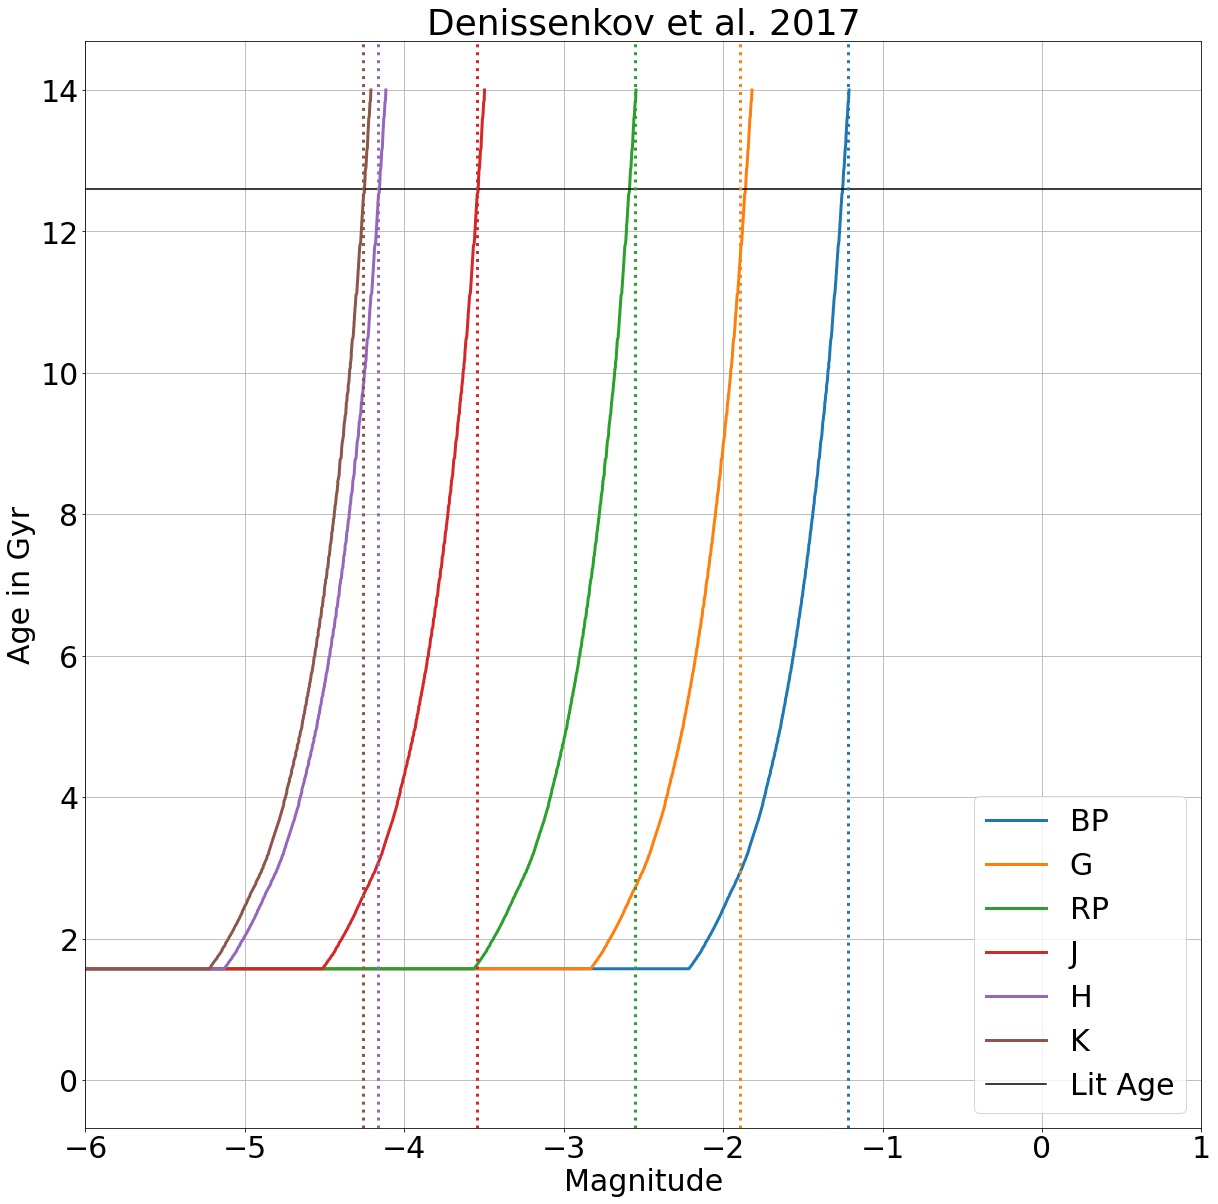

In [586]:
### Denissenkov et al. 2017

abp_g_idx = ebprp*extinct.cardelli_alav(leff['BP'],3.1)/extinct.cardelli_e12av(leff['BP'],leff['RP'],3.1)
ag_g_idx = ebprp*extinct.cardelli_alav(leff['G'],3.1)/extinct.cardelli_e12av(leff['G'],leff['RP'],3.1)
arp_g_idx = ebprp*extinct.cardelli_alav(leff['RP'],3.1)/extinct.cardelli_e12av(leff['BP'],leff['RP'],3.1)
aj_g_idx = ejh*extinct.cardelli_alav(leff['J'],3.1)/extinct.cardelli_e12av(leff['J'],leff['H'],3.1)
ah_g_idx = ejh*extinct.cardelli_alav(leff['H'],3.1)/extinct.cardelli_e12av(leff['J'],leff['H'],3.1)
ak_g_idx = ejk*extinct.cardelli_alav(leff['K'],3.1)/extinct.cardelli_e12av(leff['J'],leff['K'],3.1)

plt.figure(figsize=[20,20])
plt.plot(mag_interpbp,(10**np.unique(massive['logAge'])/10**9),label='BP',lw=3.0)
plt.plot(mag_interpg,(10**np.unique(massive['logAge'])/10**9),label='G',lw=3.0)
plt.plot(mag_interprp,(10**np.unique(massive['logAge'])/10**9),label='RP',lw=3.0)
plt.plot(mag_interpj,(10**np.unique(massive['logAge'])/10**9),label='J',lw=3.0)
plt.plot(mag_interph,(10**np.unique(massive['logAge'])/10**9),label='H',lw=3.0)
plt.plot(mag_interpk,(10**np.unique(massive['logAge'])/10**9),label='K',lw=3.0)

plt.axhline(12.6,c='k',label='Lit Age')
plt.legend()
plt.axvline(gcs['GAIA_PHOT_BP_MEAN_MAG'][g_idx]-15.02-abp_g_idx,c='tab:blue',ls=':',lw=3.0)
plt.axvline(gcs['GAIA_PHOT_G_MEAN_MAG'][g_idx]-15.02-ag_g_idx,c='tab:orange',ls=':',lw=3.0)
plt.axvline(gcs['GAIA_PHOT_RP_MEAN_MAG'][g_idx]-15.02-arp_g_idx,c='tab:green',ls=':',lw=3.0)
plt.axvline(gcs['J'][g_idx]-15.02-aj_g_idx,c='tab:red',ls=':',lw=3.0)
plt.axvline(gcs['H'][g_idx]-15.02-ah_g_idx,c='tab:purple',ls=':',lw=3.0)
plt.axvline(gcs['K'][g_idx]-15.02-ak_g_idx,c='tab:brown',ls=':',lw=3.0)
plt.xlim(-6,1)
plt.grid()
plt.title(r'Denissenkov et al. 2017')
plt.xlabel(r'Magnitude')
plt.ylabel(r'Age in Gyr')
plt.show()

In [592]:
np.diff(10**np.unique(massive['logAge']))
# 25,000,000 to 14,000,000,000 steps 25,000,000

array([25000000.00000005, 24999782.31950288, 25000218.17969972,
       24999996.25598079, 24999568.88222322, 25001221.15008572,
       24999215.7085211 , 24998693.41969231, 25001299.5914709 ,
       24998299.23462957, 25000839.02901077, 24998351.58266515,
       25004091.21673459, 24997329.2864787 , 25001102.62974894,
       25001039.06538385, 24996348.27317894, 24998656.74310654,
       25003942.93906188, 25000847.07540852, 24995751.89302152,
       25006259.63235605, 24995418.92488492, 25001702.50622642,
       24995001.15827358, 24999159.923805  , 25009023.00894856,
       25000168.65567565, 24994490.41643119, 24999143.67457199,
       25003062.08414733, 24992475.27781093, 25009603.35218346,
       25001820.11364758, 24990876.93183279, 25001509.82452583,
       24995804.16087043, 24997524.09479392, 25010362.28261137,
       24990877.1372844 , 25010817.512748  , 25002106.76235712,
       24989397.52280354, 25000266.91532683, 25012252.84871745,
       25000053.28762341, 24990785.06125

In [594]:
print('{:.3e}'.format(14000000000))

1.400e+10


(array([1.000e+00, 1.000e+00, 0.000e+00, 5.000e+00, 2.500e+01, 1.348e+03,
        6.320e+02, 3.700e+01, 4.000e+00, 1.000e+00]),
 array([-0.7564322 , -0.612857  , -0.46928176, -0.32570654, -0.18213134,
        -0.03855613,  0.10501908,  0.24859428,  0.3921695 ,  0.5357447 ,
         0.6793199 ], dtype=float32),
 <a list of 10 Patch objects>)

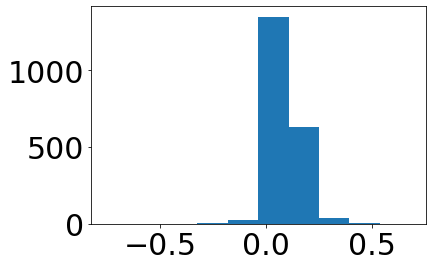

In [557]:
plt.hist(gcs['AK_TARG'])

(-10.0, 4.0)

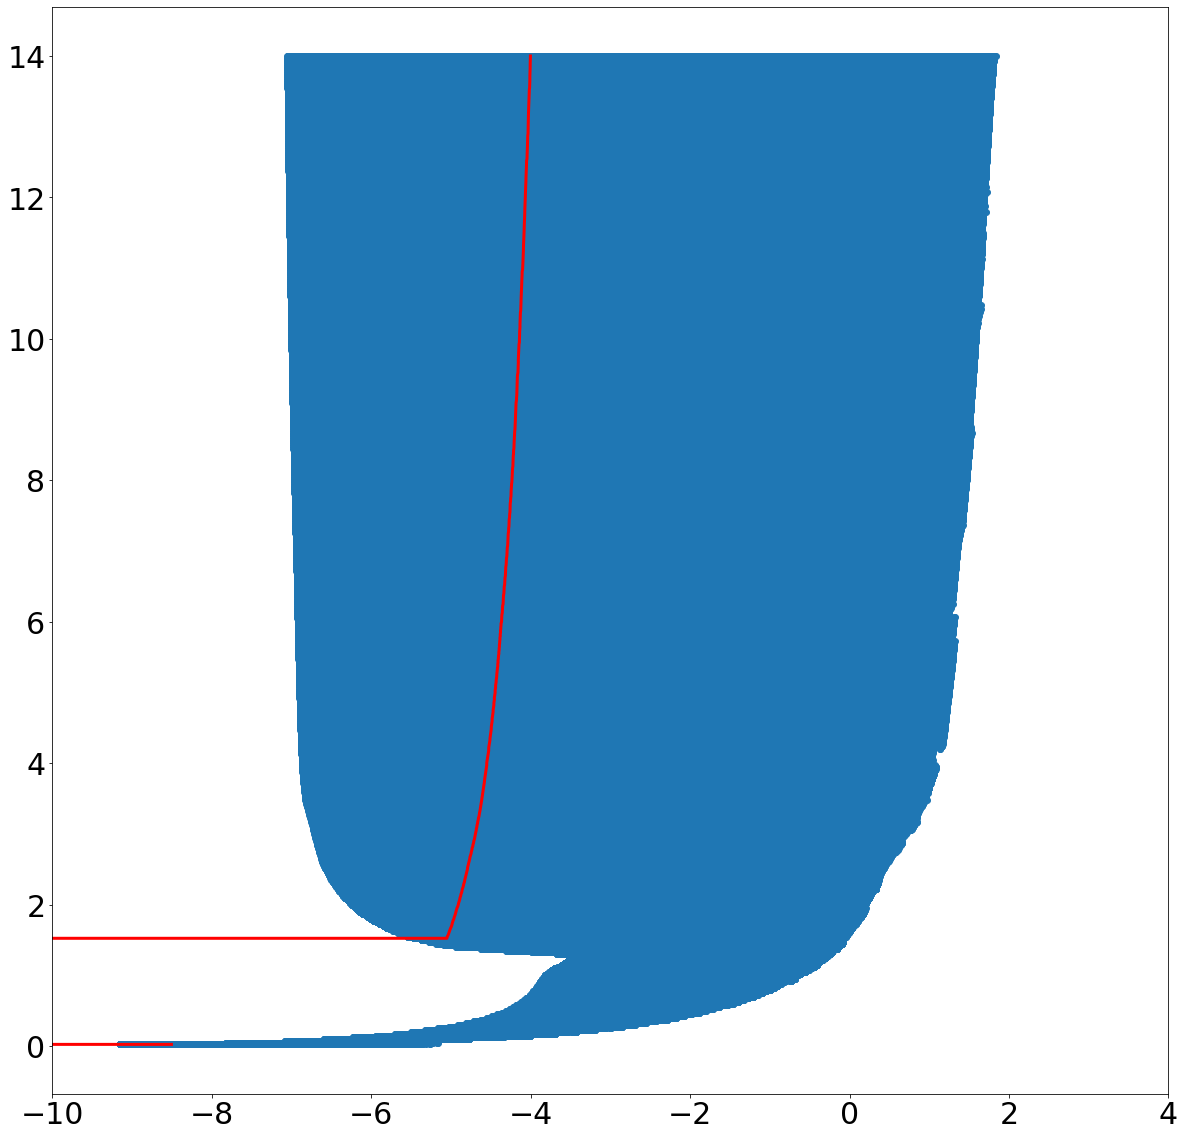

In [558]:
plt.figure(figsize=[20,20])
# test_cut = np.where((np.asarray(mag_interpk)>-6)&(np.asarray(mag_interpk)<-2))
plt.scatter(massive['Ksmag'],10**massive['logAge']/10**9)
plt.plot(np.asarray(mag_interpk),(10**np.unique(massive['logAge'])/10**9),c='r',lw=3.0)
# plt.ylim(0.,1.6)
plt.xlim(-10,4.)

(-100.0, 100.0)

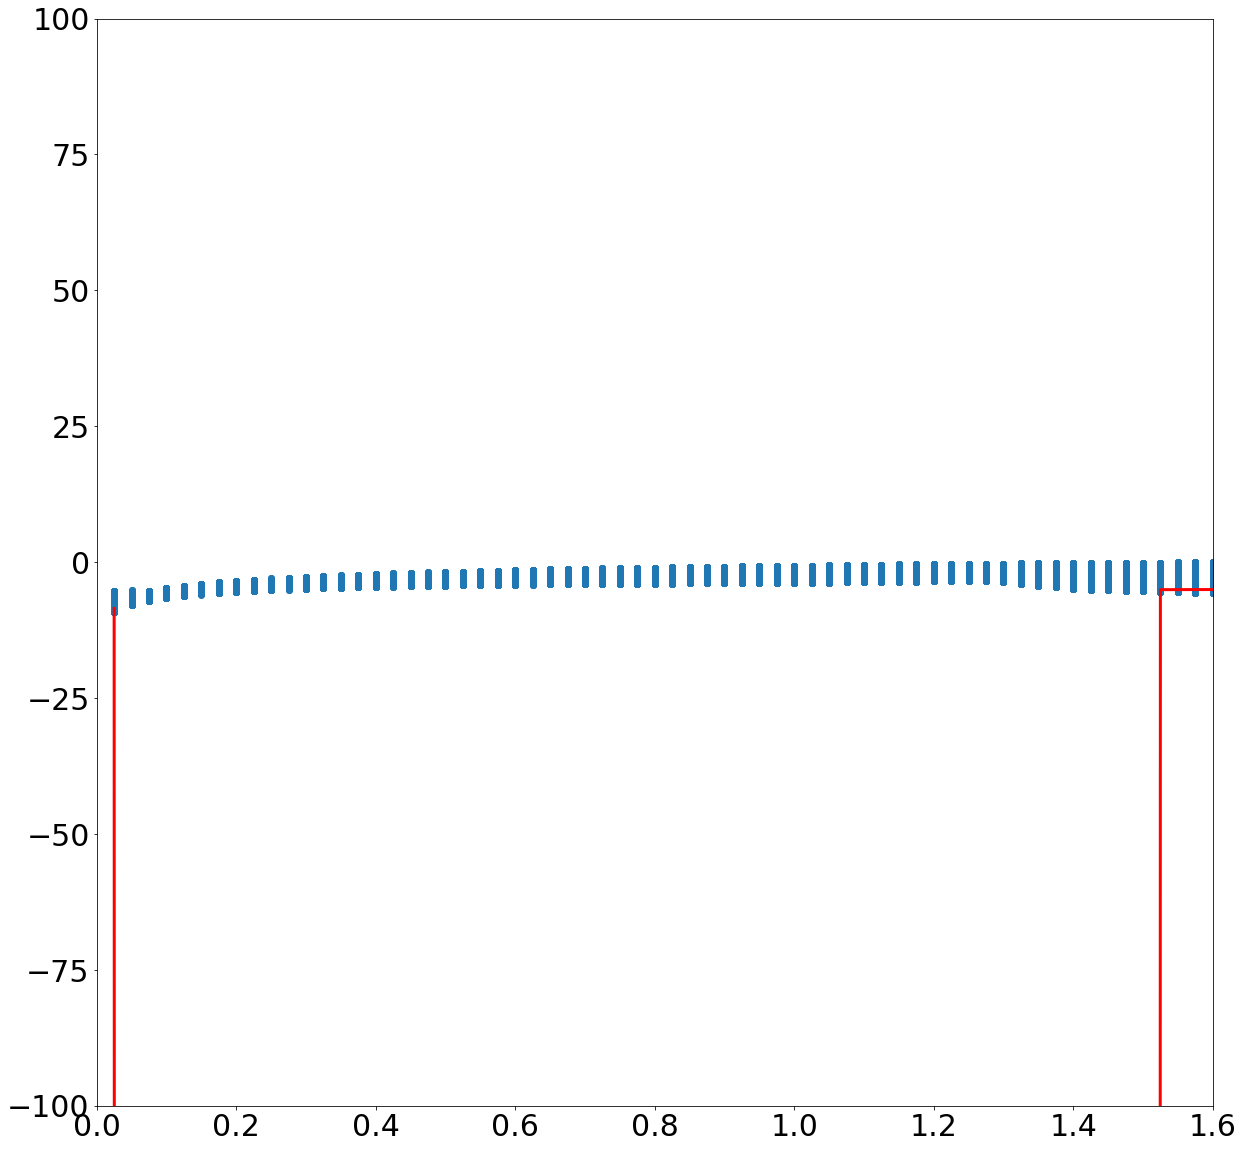

In [559]:
plt.figure(figsize=[20,20])
# test_cut = np.where((np.asarray(mag_interpk)>-6)&(np.asarray(mag_interpk)<-2))
plt.scatter(10**massive['logAge']/10**9,massive['Ksmag'])
plt.plot((10**np.unique(massive['logAge'])/10**9),np.asarray(mag_interpk),c='r',lw=3.0)
plt.xlim(0.,1.6)
plt.ylim(-100,100)

(-5.0, -2.5)

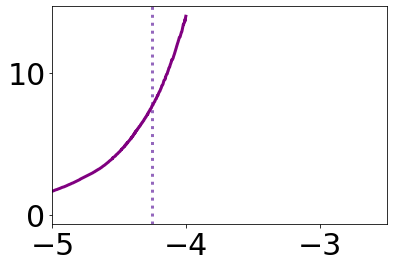

In [560]:
so = np.argsort(np.asarray(mag_interpk)[test_cut])
plt.axvline(gcs['K'][g_idx]-15.02-ak_g_idx,c='tab:purple',ls=':',lw=3.0)
plt.plot(np.asarray(mag_interpk)[test_cut][so],(10**np.unique(massive['logAge'])/10**9)[test_cut][so],
         c='purple',lw=3.0)
plt.xlim(-5,-2.5)

In [561]:
single = np.where((massive['logAge']==dln.closest(massive['logAge'],np.log10(0.8*10**9))[0])&(massive['MH']==dln.closest(massive['MH'],-1.0)[0]))

In [562]:
gcs['TEFF'][g_idx]

4470.5933

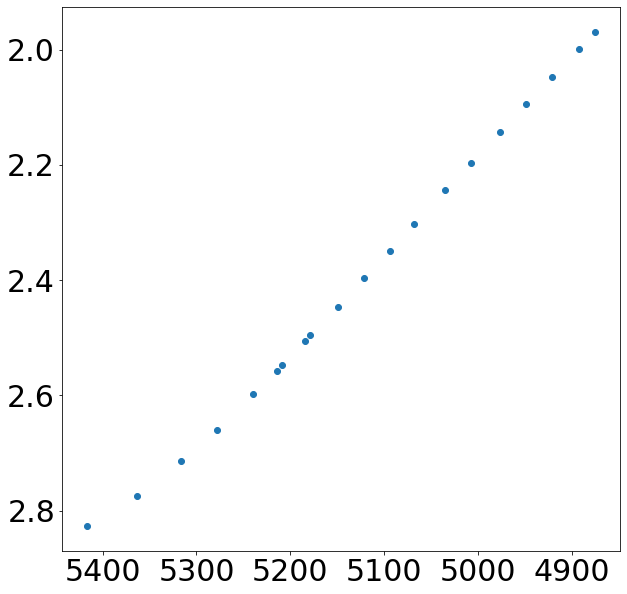

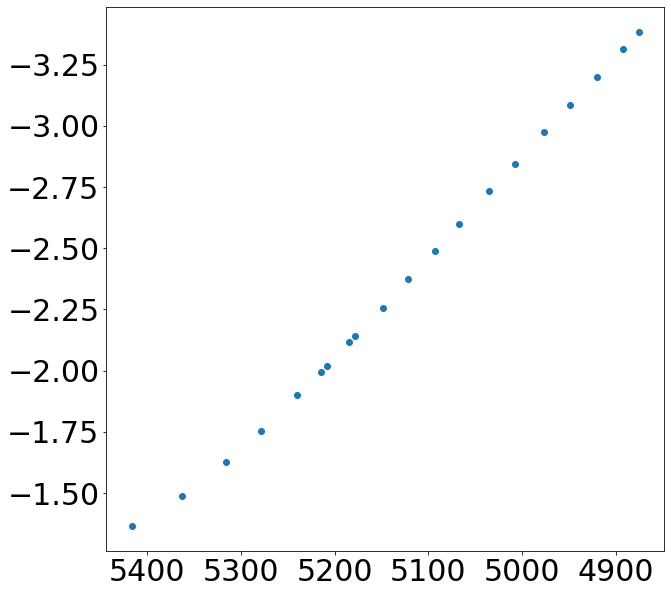

In [563]:
plt.figure(figsize=[10,10])
plt.scatter(10**massive[single]['logTe'],massive[single]['logg'])
# plt.axvline(gcs['TEFF'][g_idx])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(10**massive[single]['logTe'],massive[single]['Ksmag'])
# plt.axvline(gcs['TEFF'][g_idx])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

In [564]:
sidx = np.argsort(massive[single]['logTe'])
slogTe = massive[single]['logTe'][sidx]
smag = massive[single]['Ksmag'][sidx]
dum, ui = np.unique(slogTe,return_index=True)
spl = InterpolatedUnivariateSpline(slogTe[ui],smag[ui])
mag = spl(np.log10(gcs[g_idx]['TEFF']))
mag

array(-5.38474517)

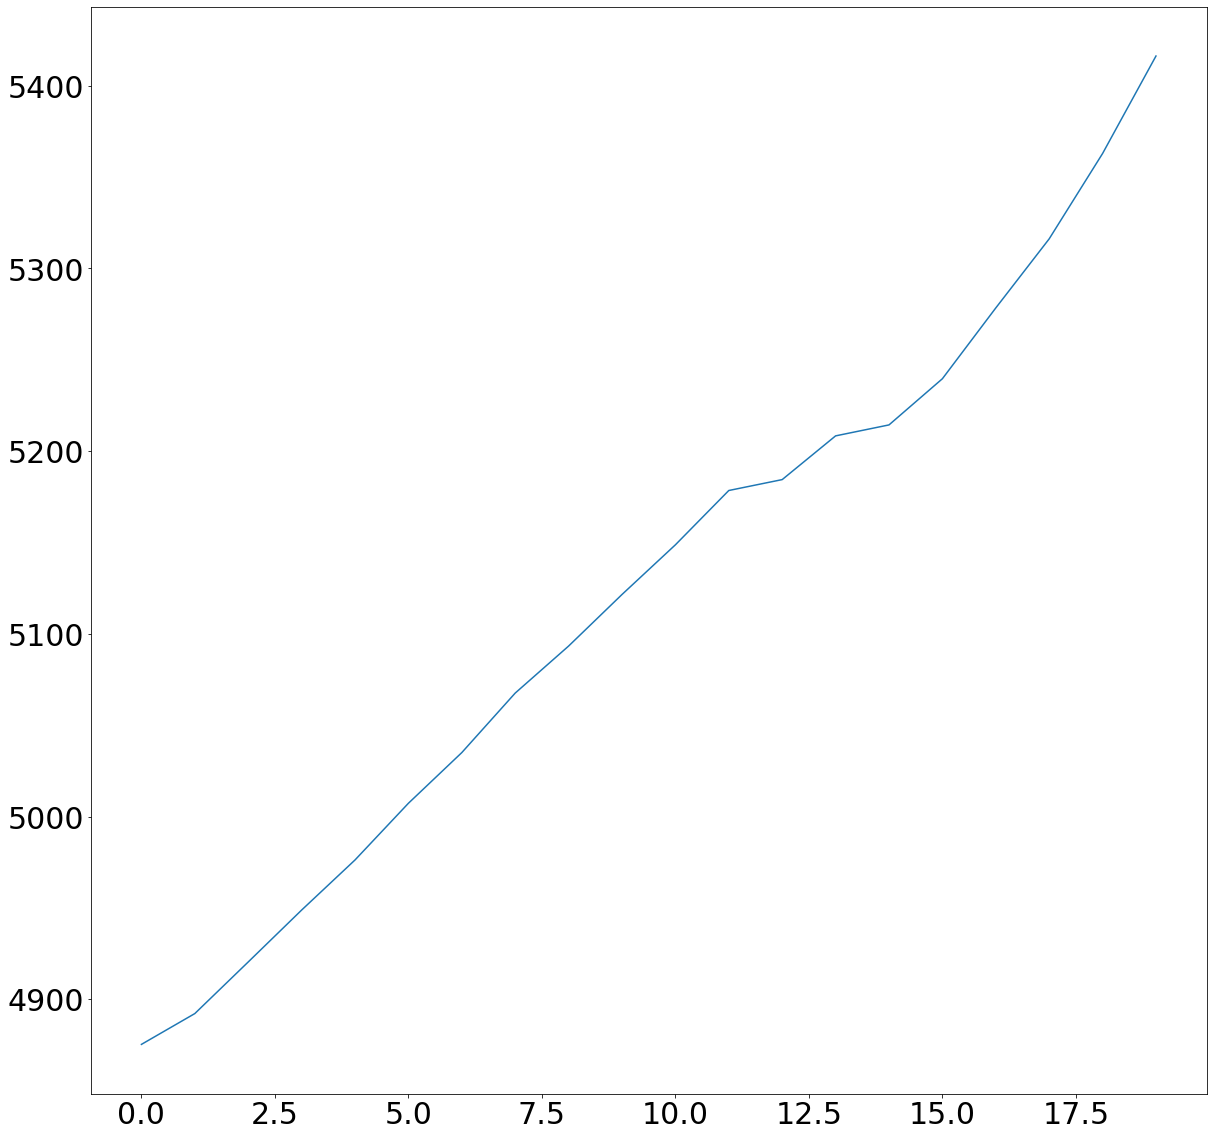

In [565]:
plt.figure(figsize=[20,20])
plt.plot(10**slogTe)

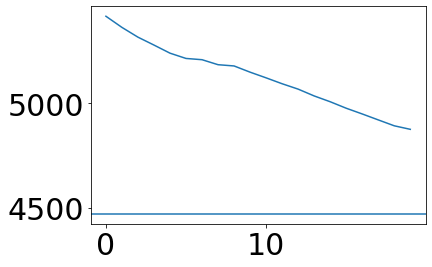

In [566]:
plt.plot(10**massive[single]['logTe'])
plt.axhline(gcs['TEFF'][g_idx])

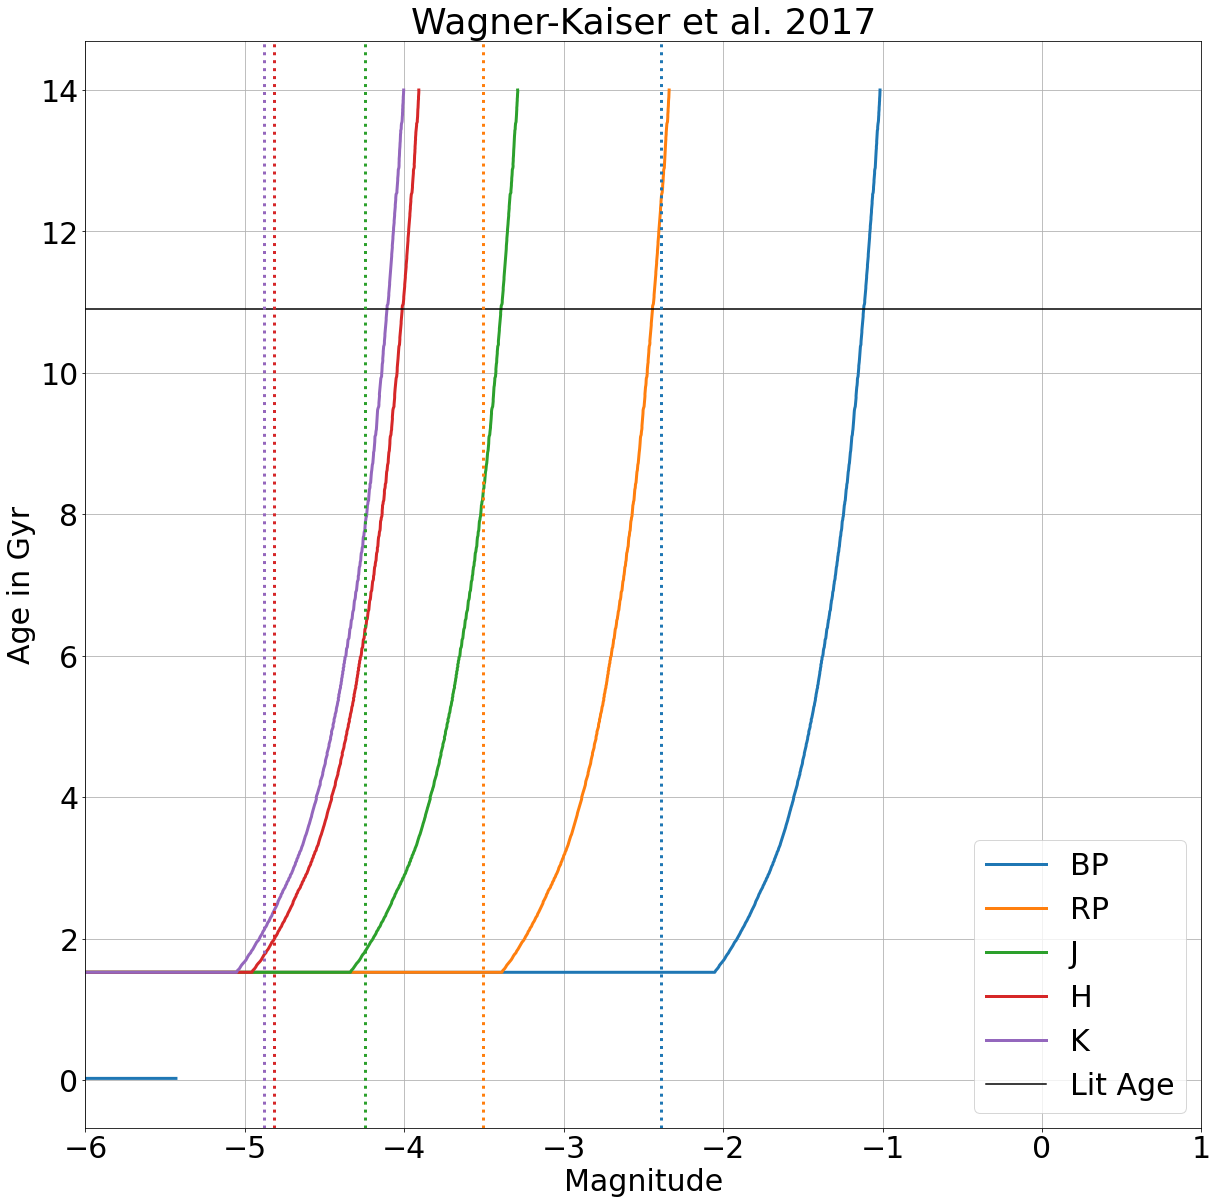

In [567]:
### Wagner-Kaiser et al. 2017

abp_g_idx_wk = 0.682*extinct.cardelli_alav(leff['BP'],3.1)
arp_g_idx_wk = 0.682*extinct.cardelli_alav(leff['RP'],3.1)
aj_g_idx_wk = 0.682*extinct.cardelli_alav(leff['J'],3.1)
ah_g_idx_wk = 0.682*extinct.cardelli_alav(leff['H'],3.1)
ak_g_idx_wk = 0.682*extinct.cardelli_alav(leff['K'],3.1)

plt.figure(figsize=[20,20])
plt.plot(mag_interpbp,(10**np.unique(massive['logAge'])/10**9),label='BP',lw=3.0)
plt.plot(mag_interprp,(10**np.unique(massive['logAge'])/10**9),label='RP',lw=3.0)
plt.plot(mag_interpj,(10**np.unique(massive['logAge'])/10**9),label='J',lw=3.0)
plt.plot(mag_interph,(10**np.unique(massive['logAge'])/10**9),label='H',lw=3.0)
plt.plot(mag_interpk,(10**np.unique(massive['logAge'])/10**9),label='K',lw=3.0)
plt.axhline(10.9,c='k',label='Lit Age')
plt.legend()
plt.axvline(gcs['GAIA_PHOT_BP_MEAN_MAG'][g_idx]-15.59-abp_g_idx_wk,c='tab:blue',ls=':',lw=3.0)
plt.axvline(gcs['GAIA_PHOT_RP_MEAN_MAG'][g_idx]-15.59-arp_g_idx_wk,c='tab:orange',ls=':',lw=3.0)
plt.axvline(gcs['J'][g_idx]-15.59-aj_g_idx_wk,c='tab:green',ls=':',lw=3.0)
plt.axvline(gcs['H'][g_idx]-15.59-ah_g_idx_wk,c='tab:red',ls=':',lw=3.0)
plt.axvline(gcs['K'][g_idx]-15.59-ak_g_idx_wk,c='tab:purple',ls=':',lw=3.0)
plt.xlim(-6,1)
plt.grid()
plt.title(r'Wagner-Kaiser et al. 2017')
plt.xlabel(r'Magnitude')
plt.ylabel(r'Age in Gyr')
plt.show()

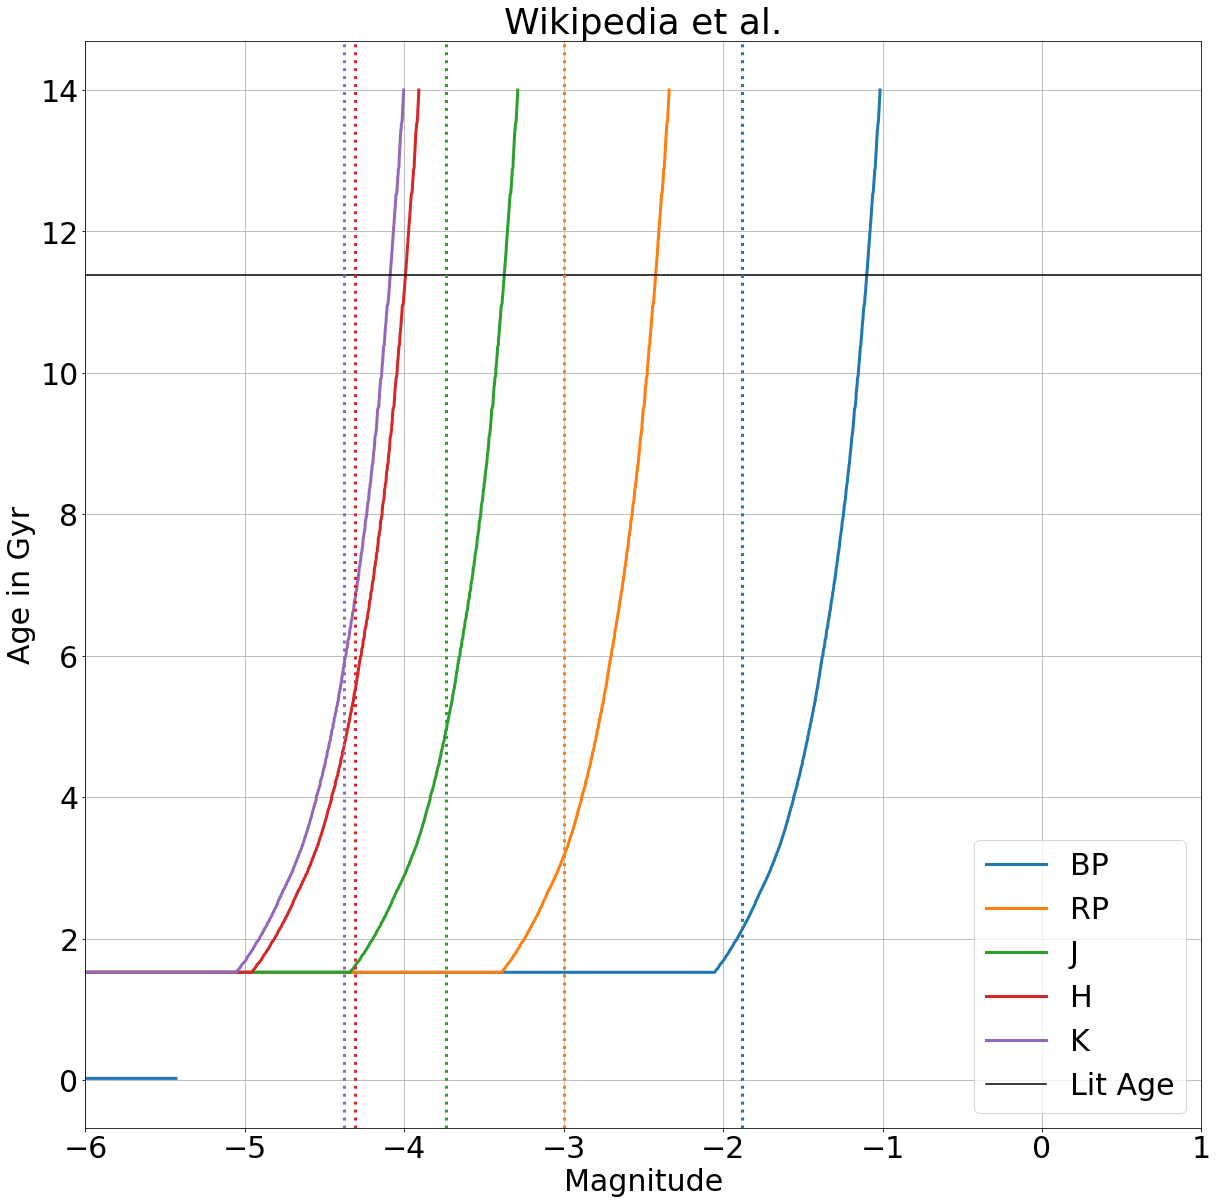

In [568]:
### Wikipedia

# distance = 10400 pc Paust et al. 2010
# age = 11.39 Gyr Forbes et al. 2010

abp_g_idx_wk = 0.682*extinct.cardelli_alav(leff['BP'],3.1)
arp_g_idx_wk = 0.682*extinct.cardelli_alav(leff['RP'],3.1)
aj_g_idx_wk = 0.682*extinct.cardelli_alav(leff['J'],3.1)
ah_g_idx_wk = 0.682*extinct.cardelli_alav(leff['H'],3.1)
ak_g_idx_wk = 0.682*extinct.cardelli_alav(leff['K'],3.1)

plt.figure(figsize=[20,20])
plt.plot(mag_interpbp,(10**np.unique(massive['logAge'])/10**9),label='BP',lw=3.0)
plt.plot(mag_interprp,(10**np.unique(massive['logAge'])/10**9),label='RP',lw=3.0)
plt.plot(mag_interpj,(10**np.unique(massive['logAge'])/10**9),label='J',lw=3.0)
plt.plot(mag_interph,(10**np.unique(massive['logAge'])/10**9),label='H',lw=3.0)
plt.plot(mag_interpk,(10**np.unique(massive['logAge'])/10**9),label='K',lw=3.0)
plt.axhline(11.39,c='k',label='Lit Age')
plt.legend()
plt.axvline(gcs['GAIA_PHOT_BP_MEAN_MAG'][g_idx]-5*np.log10(10400)+5-abp_g_idx_wk,c='tab:blue',ls=':',lw=3.0)
plt.axvline(gcs['GAIA_PHOT_RP_MEAN_MAG'][g_idx]-5*np.log10(10400)+5-arp_g_idx_wk,c='tab:orange',ls=':',lw=3.0)
plt.axvline(gcs['J'][g_idx]-5*np.log10(10400)+5-aj_g_idx_wk,c='tab:green',ls=':',lw=3.0)
plt.axvline(gcs['H'][g_idx]-5*np.log10(10400)+5-ah_g_idx_wk,c='tab:red',ls=':',lw=3.0)
plt.axvline(gcs['K'][g_idx]-5*np.log10(10400)+5-ak_g_idx_wk,c='tab:purple',ls=':',lw=3.0)
plt.xlim(-6,1)
plt.grid()
plt.title(r'Wikipedia et al.')
plt.xlabel(r'Magnitude')
plt.ylabel(r'Age in Gyr')
plt.show()